In [1]:
import pickle
from itertools import permutations, combinations
import numpy as np
import torch
import numpy as np
import pickle
from lpne.models import DcsfaNmf
from lpne.plotting import circle_plot
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
import os, sys
import seaborn as sns
import pandas as pd

umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

#pull array value from environment
#featureIdx = int(os.environ['SLURM_ARRAY_TASK_ID']) #0-91

flx_data_path = "/work/mk423/Anxiety/final_FLX_{}.pkl"
epm_data_path = "/work/mk423/Anxiety/EPM_{}_dict_May_17.pkl"
oft_data_path = "/work/mk423/Anxiety/OFT_{}_dict_old_features_hand_picked.pkl"

anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"

feature_list = ["X_psd","X_coh","X_gc"]
old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]
RANDOM_STATE = 42
EPSILON = 1e-6

anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"
anxInfoDict = pickle.load(open(anx_info_dict,"rb"))

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
brain_area_comb_idx = 0
brain_areas = anxInfoDict['area']
allFeatures = np.hstack([anxInfoDict["powerFeatures"],anxInfoDict["cohFeatures"],anxInfoDict["gcFeatures"]])
powerFeatureMask = np.zeros(len(allFeatures))
powerFeatureMask[:8*56] = 1
combinations_list = list(combinations(brain_areas, 2))
filtered_combinations = [(area1, area2) for area1, area2 in combinations_list if area1 != area2] #0-27 combinations
brain_area_1_features = np.char.find(allFeatures,filtered_combinations[brain_area_comb_idx][0]) != -1
brain_area_2_features = np.char.find(allFeatures,filtered_combinations[brain_area_comb_idx][1]) != -1
brain_comb_idxs = np.logical_and(brain_area_1_features,brain_area_2_features) + np.logical_and(brain_area_1_features,powerFeatureMask) + np.logical_and(brain_area_2_features,powerFeatureMask)


In [3]:
with open(flx_data_path.format("train"),"rb") as f:
    train_dict = pickle.load(f)
    
with open(flx_data_path.format("val"),"rb") as f:
    val_dict = pickle.load(f)
    
with open(flx_data_path.format("test"),"rb") as f:
    test_dict = pickle.load(f)
    
flx_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_train = train_dict['y_flx']
flx_y_mouse_train = train_dict['y_mouse']
flx_y_hab_train = train_dict['y_hab']
flx_y_time_train = train_dict['y_time']

flx_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_val = val_dict['y_flx']
flx_y_mouse_val = val_dict['y_mouse']
flx_y_hab_val = val_dict['y_hab']
flx_y_time_val = val_dict['y_time']

flx_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_test = test_dict['y_flx']
flx_y_mouse_test = test_dict['y_mouse']
flx_y_hab_test = test_dict['y_hab']
flx_y_time_test = test_dict['y_time']
flx_y_expDate_test = test_dict['y_expDate']

#Stack Validation and Training Data from timepoints after 30 minutes
flx_X = np.vstack([flx_X_train[flx_y_hab_train==1],flx_X_val[flx_y_hab_val==1]])
flx_y = np.hstack([flx_y_train[flx_y_hab_train==1],flx_y_val[flx_y_hab_val==1]])
flx_y_mouse = np.hstack([flx_y_mouse_train[flx_y_hab_train==1], flx_y_mouse_val[flx_y_hab_val==1]])

with open(oft_data_path.format("train"),'rb') as f:
    train_dict = pickle.load(f)

with open(oft_data_path.format("validation"),'rb') as f:
    val_dict = pickle.load(f)
    
with open(oft_data_path.format("test"),'rb') as f:
    test_dict = pickle.load(f)
    

running_idx = 0
feature_groups = []
for idx,feature in enumerate(old_feature_list):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in old_feature_list]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

#Test Arrays
oft_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_test = test_dict['y_Homecage'].astype(bool)
oft_y_task_test = ~oft_y_hc_test
oft_y_ROI_test = test_dict['y_ROI']
oft_y_vel_test = test_dict['y_vel']
oft_y_mouse_test = test_dict['y_mouse']
oft_y_time_test = test_dict['y_time']
oft_y_expDate_test = test_dict['y_expDate']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

with open(epm_data_path.format("train"),"rb") as f:
    epm_train_dict = pickle.load(f)

with open(epm_data_path.format("val"),"rb") as f:
    epm_validation_dict = pickle.load(f)
    
with open(epm_data_path.format("test"),"rb") as f:
    epm_test_dict = pickle.load(f)

#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
X_train[X_train<0] = 0
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
X_val = np.hstack([epm_validation_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])


y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = (epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)
epm_y_expDate_test = epm_test_dict['y_expDate']

X_test_task = X_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_test_task = y_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_mouse_test_task = y_mouse_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_time_test_task = y_time_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]

epm_X = np.vstack([X_train,X_val])
epm_y_task = np.hstack([y_in_task_mask_train,y_in_task_mask_val])
epm_y_mouse = np.hstack([y_mouse_train,y_mouse_val])
epm_y_time = np.hstack([y_time_train,y_time_val])

mt_X_train = np.vstack([flx_X,oft_X,epm_X])[:,brain_comb_idxs]
mt_y_train = np.hstack([flx_y,oft_y_task,epm_y_task]).reshape(-1,1)
mt_y_mouse_train = np.hstack([flx_y_mouse,oft_y_mouse,epm_y_mouse])

mt_X_test = np.vstack([flx_X_test[flx_y_hab_test==1],oft_X_test,X_test])[:,brain_comb_idxs]
mt_y_test = np.hstack([flx_y_test[flx_y_hab_test==1],oft_y_task_test,y_in_task_mask_test]).reshape(-1,1)
mt_y_mouse_test = np.hstack([flx_y_mouse_test[flx_y_hab_test==1],oft_y_mouse_test,y_mouse_test])

intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()
sample_groups = OrdinalEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1))
nmf_groups = np.hstack(
    [
        np.ones(flx_X.shape[0])*0,
        np.ones(oft_X.shape[0]),
        np.ones(epm_X.shape[0])*2
    ]
)


In [6]:
saved_model_path = "/work/mk423/Anxiety/brainRegionPairModels/"
saved_model_name = "demo_{}_{}_brainRegionPair_model_30_components.pt"

TRAIN = True
n_components=30
if TRAIN:
    model = DcsfaNmf(
        n_components=n_components,
        n_sup_networks=3,
        sup_type="sc",
        n_intercepts=intercept_mask.shape[1],
        optim_name="SGD",
        recon_loss="MSE",
        save_folder=saved_model_path,
    )

    model.fit(mt_X_train,
              mt_y_train,
              intercept_mask=intercept_mask,
              y_sample_groups=sample_groups,
              batch_size=128,
              lr=1e-3,
              n_pre_epochs=1,
              n_epochs=1,
              nmf_max_iter=1,
              nmf_groups=nmf_groups,
              bootstrap=True,
              pretrain=True,
              verbose=True,
              best_model_name=saved_model_name.format(filtered_combinations[brain_area_comb_idx][0],
                                                      filtered_combinations[brain_area_comb_idx][1]))

    torch.save(model,saved_model_path + saved_model_name.format(filtered_combinations[brain_area_comb_idx][0],
                                                      filtered_combinations[brain_area_comb_idx][1]))
else:
    model = torch.load(saved_model_path + saved_model_name.format(currentFeature,n_components),map_location="cpu")
    model.device="cpu"

(55657, 280) (55657, 3)
Pretraining NMF...


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  ConvergenceWarning,


Identifying predictive components for supervised network 0


100%|██████████| 30/30 [00:01<00:00, 15.75it/s]


Selecting network: 6 with auc 0.5307857756000905 for sup net 0 using constraint n/a correlation
Identifying predictive components for supervised network 1


100%|██████████| 30/30 [00:01<00:00, 15.26it/s]


Selecting network: 19 with auc 0.5275098880527044 for sup net 1 using constraint n/a correlation
Identifying predictive components for supervised network 2


100%|██████████| 30/30 [00:01<00:00, 15.69it/s]


Selecting network: 5 with auc 0.47499997938221195 for sup net 2 using constraint n/a correlation


Encoder Pretrain Epoch: 0, Recon Loss: 2.67394: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


Beginning Training


Epoch: 0, Current Training MSE: 0.180901, Current Training by Window ROC-AUC: [0.514357274200375]: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]

Saving the last epoch with training MSE: 0.180901 and AUCs:[0.514357274200375]


In [8]:
results_path = "/hpc/home/mk423/Anxiety/FullDataWork/Validations/RegionPairs_Check/"
results_file = results_path + "demo_{}_{}_brainRegionPair_model_30_components_results.pkl"

flx_X_test_regions = flx_X_test[flx_y_hab_test==1]
flx_X_test_regions = flx_X_test_regions[:,brain_comb_idxs==1]
flx_test_auc = model.score(flx_X_test_regions,
                      flx_y_test[flx_y_hab_test==1].reshape(-1,1),
                        flx_y_mouse_test[flx_y_hab_test==1],
                        return_dict=True)

flx_mean_test_auc = np.mean([flx_test_auc[key] for key in flx_test_auc.keys()])
flx_stderr_test_auc = np.std([flx_test_auc[key] for key in flx_test_auc.keys()]) / np.sqrt(len(flx_test_auc.keys()))

print("FLX test auc: {:.3f} +/- {:.3f}".format(flx_mean_test_auc,flx_stderr_test_auc))
print(flx_test_auc)

epm_test_auc = model.score(X_test[:,brain_comb_idxs==1],
                      y_in_task_mask_test.reshape(-1,1),
                      y_mouse_test,
                      return_dict=True)

epm_mean_test_auc = np.mean([epm_test_auc[key] for key in epm_test_auc.keys()])
epm_stderr_test_auc = np.std([epm_test_auc[key] for key in epm_test_auc.keys()]) / np.sqrt(len(epm_test_auc.keys()))

print("EPM test auc: {:.3f} +/- {:.3f}".format(epm_mean_test_auc,epm_stderr_test_auc))
print(epm_test_auc)

oft_test_auc = model.score(oft_X_test[:,brain_comb_idxs==1],
                            oft_y_task_test.reshape(-1,1),
                            oft_y_mouse_test,
                            return_dict=True)

oft_mean_test_auc = np.mean([oft_test_auc[key] for key in oft_test_auc.keys()])
oft_stderr_test_auc = np.std([oft_test_auc[key] for key in oft_test_auc.keys()]) / np.sqrt(len(oft_test_auc.keys()))
print("OFT test auc: {:.3f} +/- {:.3f}".format(oft_mean_test_auc,oft_stderr_test_auc))
print(oft_test_auc)

s = model.project(mt_X_test)
X_recon = model.reconstruct(mt_X_test)+ EPSILON
perc_recon_list = []
for i in range(3):
    X_sup_recon = model.get_comp_recon(torch.Tensor(s).to(model.device),i) + EPSILON
    net_recon_contribution = np.mean(X_sup_recon/X_recon,axis=0) 
    perc_recon_list.append(net_recon_contribution)

results_dict = {
    "flx_auc":flx_test_auc,
    "flx_mean_test_auc":flx_mean_test_auc,
    "flx_stderr_test_auc":flx_stderr_test_auc,

    "epm_auc":epm_test_auc,
    "epm_mean_test_auc":epm_mean_test_auc,
    "epm_stderr_test_auc":epm_stderr_test_auc,

    "oft_auc":oft_test_auc,
    "oft_mean_test_auc":oft_mean_test_auc,
    "oft_stderr_test_auc":oft_stderr_test_auc,

    "recon_hist":model.recon_hist,
    "pred_hist":model.pred_hist,
    "n_components":n_components,
    "coefficients":model.classifier[0].weight[0].detach().cpu().numpy(),
    "s_avg":np.mean(s,axis=0)[:3],
    "regions":(filtered_combinations[brain_area_comb_idx][0],filtered_combinations[brain_area_comb_idx][1]),
}

with open(results_file.format(filtered_combinations[brain_area_comb_idx][0],filtered_combinations[brain_area_comb_idx][1]),"wb") as f:
    pickle.dump(results_dict,f)
    
print("regions",results_dict["regions"])

FLX test auc: 0.519 +/- 0.011
{'Mouse69061': [0.47915718863391404], 'Mouse78732': [0.5693263694970179], 'Mouse78743': [0.525877593495935], 'Mouse78745': [0.5118861459697651], 'Mouse78751': [0.5241407781775265], 'Mouse78764': [0.5065391108719723]}
EPM test auc: 0.506 +/- 0.011
{'Mouse0641': [0.45648734177215194], 'Mouse39115': [0.5342213732783754], 'Mouse39121': [0.5155287205021081], 'Mouse39122': [0.5230475690518495], 'Mouse39132': [0.5468587623996221], 'Mouse39135': [0.5249994270129037], 'Mouse6674': [0.5036476426799007], 'Mouse69061': [0.4789746106822542], 'Mouse69071': [0.5494694750178161], 'Mouse69075': [0.5067155449722187], 'Mouse8893': [0.4256101758109387]}
OFT test auc: 0.541 +/- 0.013
{'Mouse04203': [0.5184240899114508], 'Mouse39115': [0.4842671587423312], 'Mouse39121': [0.5445802866335185], 'Mouse39122': [0.5906135775205604], 'Mouse39132': [0.5867438979330131], 'Mouse39135': [0.48630557259998886], 'Mouse69061': [0.5167999426255961], 'Mouse69071': [0.5829657261343308], 'Mouse69

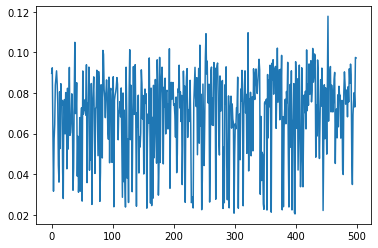

In [42]:
plt.plot(model.recon_hist)

In [46]:
from sklearn.decomposition import NMF

unsup_recon = NMF(n_components=30,max_iter=2000)
unsup_recon.fit(mt_X_train)

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


NMF(max_iter=2000, n_components=30)

In [47]:
unsup_recon.reconstruction_err_

275.80474298056134

In [52]:
unsup_recon.components_.shape

(30, 280)

In [55]:
np.mean((mt_X_test - unsup_recon.transform(mt_X_test) @ unsup_recon.components_)**2)

0.0038689160119302645

In [57]:
np.std(mt_X_train)**2

0.06624955902726991